In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

2015 CAASPP test results, scatterplots

* [Source Website](http://caaspp.cde.ca.gov/sb2015/ResearchFileList)
* [Data Dictionary](http://caaspp.cde.ca.gov/sb2015/research_fixfileformat)

The county code for San Diego is 37.

The most important measurement values are: 
* pct_msa. The percentage of a subgroup that tested at or above the "Meets Standards" level. MSA = "Meet Standards or Above"
* mss. Mean Scale Score. The average test score for the subgroup. 

The geo_decomp() call seperates out the counties, schools and districts and limits the data to one grade. 

The first input cell restricts the data to the English Language Arts test. 


In [103]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
df = pd.read_csv('../ca2015_all_csv_v1.txt', na_values='*'  )

# Entities. The school, district and county names. 
ent = pd.read_csv('../ca2015entities_csv.txt')

# Here is where we specify which test. 1 is the English / Language Arts test. 
#df = df[df['Test Id'] == 1]

# Create an identifier that combines the three codes. This ID is typical in other education files, 
# buyt oddly lacking from this one. 
def f(x):
    return "{:02d}{:05d}{:07d}".format(x['County Code'],x['District Code'],x['School Code'])
   
df['cds'] = df.apply(f, axis=1)
ent['cds'] = ent.apply(f, axis=1)
ent.set_index('cds',inplace = True) # index on cds so we can easily merge. 

county_names = ent['County Name']
school_names = ent['School Name']
district_names = ent[['District Name', 'County Name']]

# Friendly names of the subgroups. 
subgroups = pd.read_csv('../Subgroups.txt', header=None, names = ['subgroup_id','subgroup_name','category'],
                       index_col = 0)
subgroups['title'] = subgroups.apply(lambda row: row['category']+"; "+row['subgroup_name'], axis=1)
subgroup_names = subgroups.to_dict()['title']

# Calculate the percentage of students in the school, county or district who are members of the subgroup
df['pct_subgroup'] = df['Total Tested At Subgroup Level'] / df['Total Tested At Entity Level']

In [112]:
def col_subset(df):
    dfs = df[['cds', 'County Code', 'Subgroup ID', 'pct_subgroup', 'Grade', 'Test Id', 'Mean Scale Score', 
             'Percentage Standard Met and Above']]
    dfs.columns = [u'cds', 'county',  u'subgroup', u'pct_subgroup', u'grade', 'test', u'mss', u'pct_msa']
    return dfs

def subset(grade, df):
    """Make Pretty column names and select the grade. """
    dfs = col_subset(df)
    return dfs[dfs.grade == grade]

def geo_decomp(grade):
    """Decompose the dataframe into entries for school, district and county. Also create pivoted version of each, 
    where the subgroups are seperated into columns on the pct_msa field. """
    
    schools = subset(grade, df[df['School Code'] != 0])
    districts =  subset(grade, df[(df['District Code'] != 0) & (df['School Code'] == 0)])
    counties =  subset(grade, df[ (df['County Code'] != 0) & (df['District Code'] == 0) & (df['School Code'] == 0)])
    states =  subset(grade, df[ (df['County Code'] == 0)])

    counties_p = pd.pivot_table(counties,index='cds', columns='subgroup', values='pct_msa')
    districts_p = pd.pivot_table(districts[districts.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    schools_p = pd.pivot_table(schools[schools.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    
    return (states, counties, counties_p, districts, districts_p, schools, schools_p)
   
def munge_sg_cols(df):
    """Change the subgroup numbers in column numbers ( in the pivoted versions of the outputs from geo_decomp() )
    to human-friendly names"""
    df.columns = [ subgroup_names.get(e,e).strip().strip('"') for e in df.columns ]
    return df
    

In [4]:
#
# Support functions for scatter plots. 
#
def sg_cross(df, subgroups):
    """Select a limited subset of subgroup ids and index them on the entity ( county, district, school, via CDS)
    and the subgroup"""
    d = df[df.subgroup.isin(subgroups)].set_index(['cds','subgroup'])[['pct_subgroup','pct_msa']]
    e = d.unstack(1)
    
    # Alter the column headings to include the subgroup id. So, the 'pct_subgroup' value for subgroup 10 will be
    # renamed 'pct_subgroup_10' 
    e.columns = [ "{}_{}".format(*c) for c in e.columns.values]
    return e

def fit_plot(entity, grade, df, x_sg, y_sg):
    """Scatter plot and regression line for how % proficient for subgroup 2 changes
    in response to subgroup 1
    
    df is the data frame to use. It should be restricted to one of the entity data frames, 
    schools, districts or counties. 
    
    x_sg is the subgroup id for the X axis. The X value will be the % of the entity that is 
    composed of the given subgroup
    
    y_sg is the subgroup id for the Y axis. The Y value will be the pct_msa for the sg_y subgroup at that entity. 
    
    """
    import matplotlib.pyplot as plt
    # fit with np.polyfit
    e = sg_cross(df, (x_sg, y_sg))
    
    #print 'Dropping these records'
    #print e[e.isnull().any(axis=1)].join(ent)[['District Name', 'School Name']]
    e = e.dropna()
    
    x = e['pct_subgroup_{}'.format(x_sg)]
    y = e['pct_msa_{}'.format(y_sg)]
    
    m, b = np.polyfit(x,y, 1)

    x_sg_name = subgroup_names[x_sg]
    y_sg_name = subgroup_names[y_sg]
    
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    
    fig.suptitle('MSA of {} \nvs\n% in group {}'.format(y_sg_name, x_sg_name), fontsize=14, fontweight='bold', y=.98)
    ax.set_title("By {}, Grade {}".format(entity, grade))

    
    ax.set_xlabel('% of entity students in group "{}"'.format(x_sg_name))
    ax.set_ylabel('% of group "{}"  at MSA'.format(y_sg_name))
    
    ax.plot(x, y, 'o')
    ax.plot(x, m*x + b, '-')

    names = list(e.join(ent)['District Name'])
    
    if len(names) < 35:
        for name, xy in zip(names, zip(x,y)):                                            
            ax.annotate( name, xy=xy, xytext=(0,0), textcoords='offset points',
                       rotation = -20) 
    
def fit_plot_sd_schools(grade, x_sg, y_sg):
    state, counties, counties_p, districts, districts_p, schools, schools_p = geo_decomp(grade)
    fit_plot('Schools in San Diego County', grade, schools[schools.county == 37], x_sg, y_sg)
    
def fit_plot_sd_districts(grade, x_sg, y_sg):
    state, counties, counties_p, districts, districts_p, schools, schools_p = geo_decomp(grade)
    fit_plot('Districts in San Diego County', grade, districts[districts.county == 37], x_sg, y_sg)    

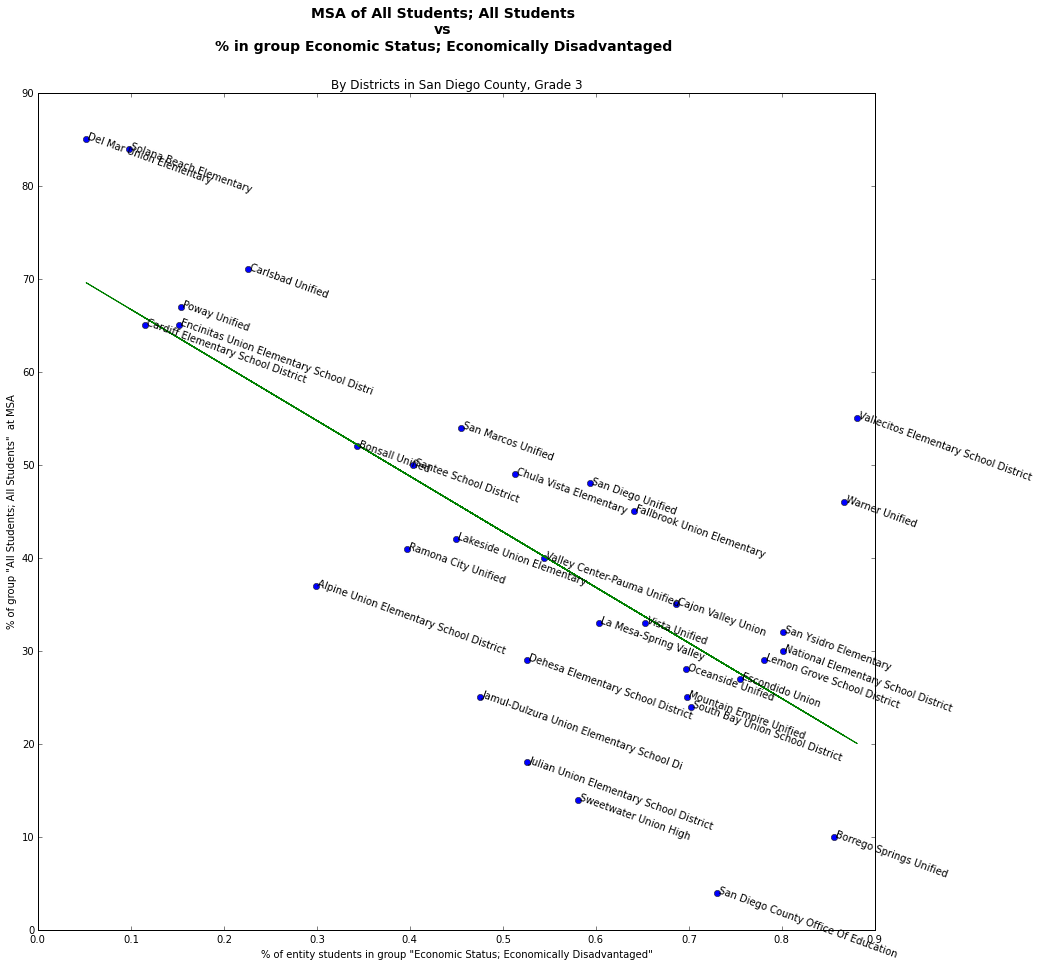

In [6]:

fit_plot_sd_districts( 3, 31, 1) 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
df = pd.read_csv('../ca2015_all_csv_v1.txt', na_values='*'  )

# Entities. The school, district and county names. 
ent = pd.read_csv('../ca2015entities_csv.txt')

# Here is where we specify which test. 1 is the English / Language Arts test. 
df = df[df['Test Id'] == 1]

# Create an identifier that combines the three codes. This ID is typical in other education files, 
# buyt oddly lacking from this one. 
def f(x):
    return "{:02d}{:05d}{:07d}".format(x['County Code'],x['District Code'],x['School Code'])
   
df['cds'] = df.apply(f, axis=1)
ent['cds'] = ent.apply(f, axis=1)
ent.set_index('cds',inplace = True) # index on cds so we can easily merge. 

county_names = ent['County Name']
school_names = ent[['School Name','District Name', 'County Name']]
district_names = ent[['District Name', 'County Name']]

# Friendly names of the subgroups. 
subgroups = pd.read_csv('../Subgroups.txt', header=None, names = ['subgroup_id','subgroup_name','category'],
                       index_col = 0)
subgroups['title'] = subgroups.apply(lambda row: row['category']+"; "+row['subgroup_name'], axis=1)
subgroup_names = subgroups.to_dict()['title']

# Calculate the percentage of students in the school, county or district who are members of the subgroup
df['pct_subgroup'] = df['Total Tested At Subgroup Level'] / df['Total Tested At Entity Level']

In [ ]:
fit_plot_sd_districts( 7, 31, 1) 

In [ ]:
fit_plot_sd_districts( 11, 31, 1) 

In [117]:

schools = col_subset(df[df['School Code'] != 0])
schools = schools[(schools.county == 37) & (schools.subgroup == 31)]
school_names = ent[['School Name','District Name', 'County Name']]
ed_rate = schools[(schools.subgroup == 31)][['cds', 'pct_subgroup']].copy()
ed_rate.columns = ['cds', 'pct_ec_disadvantaged']
ed_rate.pct_ec_disadvantaged = np.round(ed_rate.pct_ec_disadvantaged *100,0)
ed_rate = ed_rate.groupby('cds').max()

In [122]:
high_ed_x = schools[(schools.county==37) & (schools.subgroup == 31)].set_index('cds').join(school_names)\
.sort('pct_msa', ascending = False).join(ed_rate)

high_ed = high_ed_x[high_ed_x.pct_ec_disadvantaged > 60].sort('pct_msa', ascending = False).dropna()

In [126]:
high_ed[( high_ed.grade == 3 ) & ( high_ed.test == 1 ) ].sort('pct_msa', ascending = False).dropna()

,county,subgroup,pct_subgroup,grade,test,mss,pct_msa,School Name,District Name,County Name,pct_ec_disadvantaged
cds,,,,,,,,,,,
37242060124206,37,31,0.938650,3,1,2484.1,77,America's Finest Charter,America's Finest Charter,San Diego,94
37680236037964,37,31,0.700935,3,1,2453.3,63,Finney (Myrtle S.) Elementary,Chula Vista Elementary,San Diego,70
37683386093256,37,31,0.607774,3,1,2435.9,58,Miller Elementary,San Diego Unified,San Diego,61
37680236037972,37,31,0.741463,3,1,2452.5,58,Palomar Elementary,Chula Vista Elementary,San Diego,74
37683386039481,37,31,0.670103,3,1,2443.3,56,Dewey Elementary,San Diego Unified,San Diego,67
37683386039804,37,31,0.662791,3,1,2425.7,54,Juarez Elementary,San Diego Unified,San Diego,66
37683386039309,37,31,0.625000,3,1,2428.4,53,Cadman Elementary,San Diego Unified,San Diego,62
37683386039887,37,31,0.714894,3,1,2438.1,53,Lindbergh/Schweitzer Elementary,San Diego Unified,San Diego,71
37683386077317,37,31,0.762431,3,1,2427.6,53,Penn Elementary,San Diego Unified,San Diego,76


In [125]:
high_ed.to_csv('high_ed.csv')